# Setup

Clear previous Brian2 runs

In [210]:
from brian2 import *
import numpy as np
start_scope()

Parameters

In [211]:
N_total = 1000
sim_duration = 100 * second
p_E = 0.8
N_dict = {'E': int(round(N_total * p_E)),
          'I': N_total - int(round(N_total * p_E))}
indices = {'E': np.arange(N_dict['E']),
           'I': np.arange(N_dict['E'], N_total)}
p = {'EE': 0.9, 'EI': 0.5, 'IE': 0.5, 'II': 0.5}
N_indegree = {k: int(round(N_dict[k[1]] * p[k])) for k in p}

R_m = 1e5 * ohm
C_m = 20 * nfarad
tau_m = R_m * C_m
tau_pre = 20 * ms
tau_post = tau_pre
tau_e = 20 * ms
tau_i = tau_e
refract_period = 5 * ms

V_rest = -60 * mV
V_reset = -60 * mV
V_thr = -55 * mV
E_e = 0 * mV
E_i = -75 * mV
g_L = 1 / R_m
THETA = 53 * nA

F = 15 * Hz
gmax = 1
dApre = 0.01 * gmax
dApost = -0.01 * gmax * tau_pre / tau_post * 1.05

record_from = [0, 10, 110, 120]

eqs = '''
dV/dt = (g_L*(V_rest - V) + ge*(E_e - V) + gi*(E_i - V) + THETA)/C_m : volt
dge/dt = -ge/tau_e : siemens
dgi/dt = -gi/tau_i : siemens
'''

neurons = NeuronGroup(N_total, eqs, threshold='V>V_thr', reset='V=V_reset',
                      refractory=refract_period, method='euler')
neurons.V = V_rest

pre_post = {}
for key in N_indegree:
    pre_list, post_list = [], []
    for j in indices[key[0]]:
        candidates = indices[key[1]]
        if key[0] == key[1]:
            candidates = np.delete(candidates, np.where(candidates == j)[0])
        sample_size = min(N_indegree[key], len(candidates))
        chosen = np.random.choice(candidates, size=sample_size, replace=False)
        pre_list.append(chosen)
        post_list.append(np.full(sample_size, j))
    pre_post[key] = (np.concatenate(pre_list), np.concatenate(post_list))

w = {'EI': 30 * nsiemens, 'IE': 230 * nsiemens, 'II': 230 * nsiemens}
wEEmax = gmax * nsiemens

S_dict = {}
for key, (pre, post) in pre_post.items():
    if key == 'EE':
        syn = Synapses(neurons, neurons,
                       '''w : siemens
dApre/dt = -Apre/tau_pre : siemens (event-driven)
dApost/dt = -Apost/tau_post : siemens (event-driven)''',
                       on_pre='ge += w\nApre += dApre\nw = clip(w + Apost, 0*siemens, wEEmax)',
                       on_post='Apost += dApost\nw = clip(w + Apre, 0*siemens, wEEmax)',
                       method='euler')
    else:
        target = 'ge' if key[1]=='E' else 'gi'
        syn = Synapses(neurons, neurons, model='w_const : siemens',
                       on_pre=f"{target} += w_const")
    syn.connect(i=pre, j=post)
    if key != 'EE':
        syn.w_const = w[key]
    S_dict[key] = syn

S_dict['EE'].w = 'rand()*wEEmax'

spike_mon = SpikeMonitor(neurons)
syn_mon = StateMonitor(S_dict['EE'], 'w', record=record_from)
state_mon = StateMonitor(neurons, ['V','ge','gi'], record=record_from)

WARNING    The object 'synapses_16' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\adeet\AppData\Local\Temp\ipykernel_25124\1518767979.py', line 73, in <module>
    syn = Synapses(neurons, neurons, model='w_const : siemens', [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_17' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\adeet\AppData\Local\Temp\ipykernel_25124\1518767979.py', line 73, in <module>
    syn = Synapses(neurons, neurons, model='w_const : siemens', [brian2.core.base.unused_brian_object]


# Run

In [212]:
run(sim_duration, report='text')

WARNING    The object 'synapses_12' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\adeet\AppData\Local\Temp\ipykernel_25124\1672446555.py', line 73, in <module>
    syn = Synapses(neurons, neurons, model='w_const : siemens', [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did not store the object reference in a variable, or that the variable was not used to construct the network.
The object was created here (most recent call only):
  File 'C:\Users\adeet\AppData\Local\Temp\ipykernel_25124\1672446555.py', line 41, in <module>
    neurons = NeuronGroup(N_total, eqs, threshold='V>V_thr', reset='V=V_reset', [brian2.core.base.unused_brian_object]
WARNING    'stat

Starting simulation at t=0. s for a duration of 100. s
10.5073 s (10%) simulated in 10s, estimated 1m 25s remaining.
21.4789 s (21%) simulated in 20s, estimated 1m 13s remaining.
31.8004 s (31%) simulated in 30s, estimated 1m 4s remaining.
41.3914 s (41%) simulated in 40s, estimated 57s remaining.
51.3093 s (51%) simulated in 50s, estimated 47s remaining.
61.3603 s (61%) simulated in 1m 0s, estimated 38s remaining.
69.6665 s (69%) simulated in 1m 10s, estimated 30s remaining.
80.1043 s (80%) simulated in 1m 20s, estimated 20s remaining.
90.9171 s (90%) simulated in 1m 30s, estimated 9s remaining.
100. s (100%) simulated in 1m 38s


# Analyze

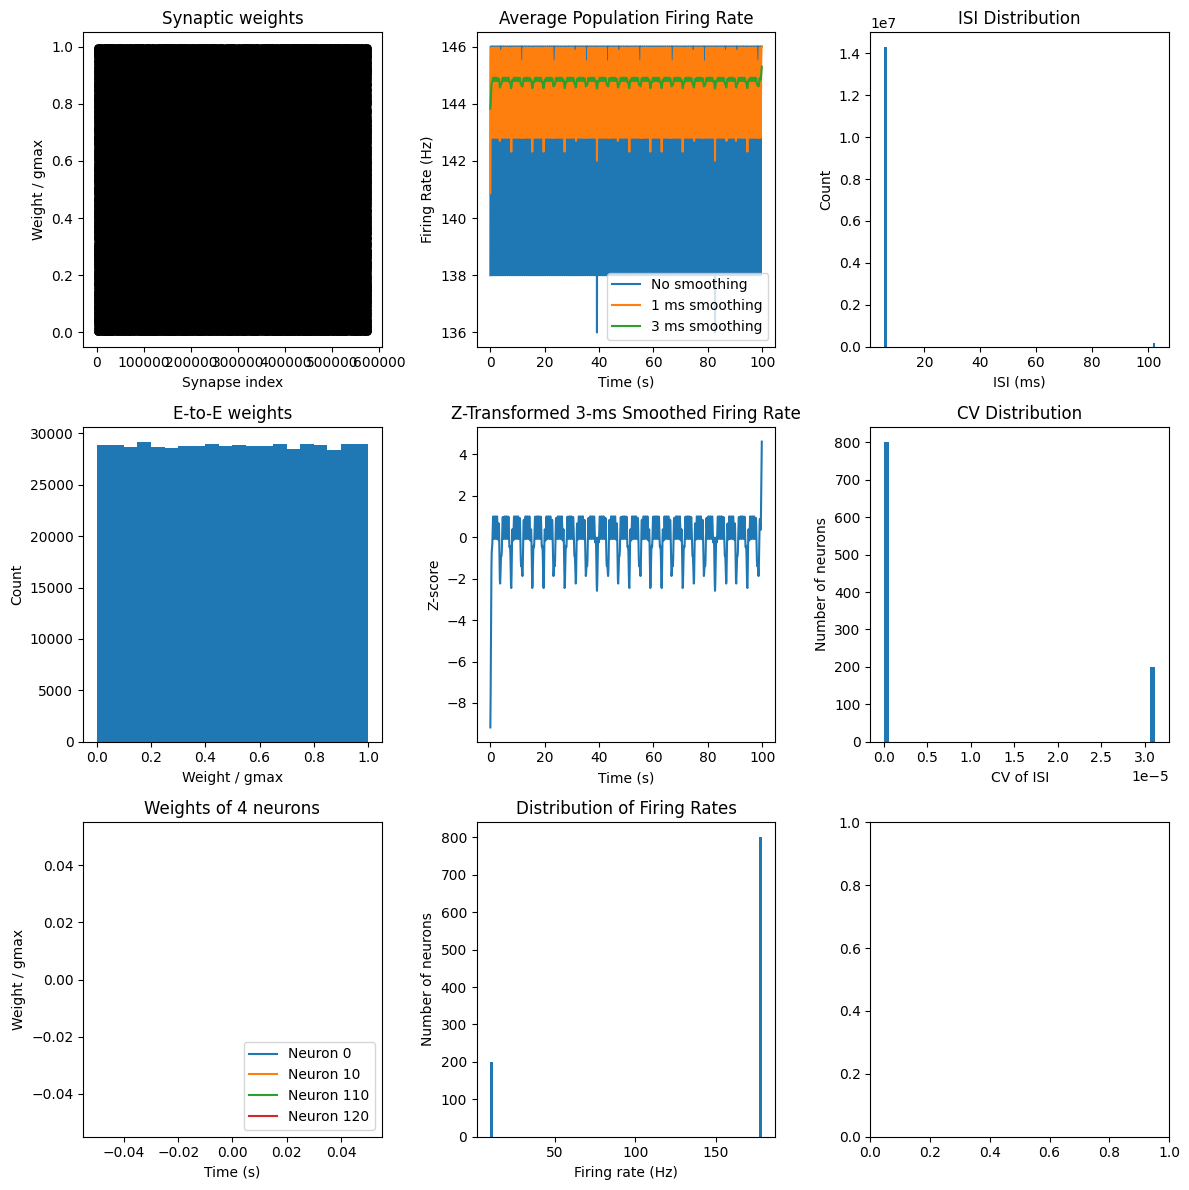

In [217]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

S = S_dict['EE']

# Synaptic weights figures
ax[0, 0].plot(S.w / wEEmax, '.k')
ax[0, 0].set_xlabel('Synapse index')
ax[0, 0].set_ylabel('Weight / gmax')
ax[0, 0].set_title('Synaptic weights')

ax[1, 0].hist(S.w / wEEmax, 20)
ax[1, 0].set_xlabel('Weight / gmax')
ax[1, 0].set_ylabel('Count')
ax[1, 0].set_title('E-to-E weights')

ax[2, 0].plot(syn_mon.t/second, syn_mon.w.T/gmax, label=[f'Neuron {i}' for i in record_from])
ax[2, 0].set_xlabel('Time (s)')
ax[2, 0].set_ylabel('Weight / gmax')
ax[2, 0].set_title(f'Weights of {len(record_from)} neurons')
ax[2, 0].legend(loc='lower right')

# Population firing rate
from scipy.ndimage import gaussian_filter1d
spike_times = np.array(spike_mon.t / second)
bin_width = 100 * ms
bins = np.arange(0, sim_duration, bin_width / second)
spike_counts, _ = np.histogram(spike_times, bins)
avg_firing_rate = spike_counts / (N_total * bin_width)
smoothed_1 = gaussian_filter1d(avg_firing_rate, sigma=1)
smoothed_3 = gaussian_filter1d(avg_firing_rate, sigma=3)
time_bins = bins[:-1] + bin_width / (2 * second)

ax[0, 1].plot(time_bins, avg_firing_rate, label='No smoothing')
ax[0, 1].plot(time_bins, smoothed_1, label='1 ms smoothing')
ax[0, 1].plot(time_bins, smoothed_3, label='3 ms smoothing')
ax[0, 1].set_xlabel('Time (s)')
ax[0, 1].set_ylabel('Firing Rate (Hz)')
ax[0, 1].set_title('Average Population Firing Rate')
ax[0, 1].legend(loc='lower right')

z_rate_E = (lambda x: (x - np.mean(x)) / np.std(x))(smoothed_3)
ax[1, 1].plot(time_bins, z_rate_E)
ax[1, 1].set_xlabel('Time (s)')
ax[1, 1].set_ylabel('Z-score')
ax[1, 1].set_title('Z-Transformed 3-ms Smoothed Firing Rate')

spike_counts = np.bincount(spike_mon.i, minlength=N_total)
firing_rate = spike_counts / (sim_duration / second)
ax[2, 1].hist(firing_rate, bins=100)
ax[2, 1].set_xlabel('Firing rate (Hz)')
ax[2, 1].set_ylabel('Number of neurons')
ax[2, 1].set_title('Distribution of Firing Rates')

# ISI and CVs
ISIs = []
spike_train_dict = spike_mon.spike_trains()
for i in range(N_total):
    times = spike_train_dict[i]
    if len(times) > 1:
        isi = np.diff(times)
        ISIs.append(isi)
all_ISIs = np.hstack(ISIs)
CVs = [np.std(isi)/np.mean(isi) for isi in ISIs if len(isi) > 1]

ax[0, 2].hist(all_ISIs * second / ms, bins=100)
ax[0, 2].set_xlabel('ISI (ms)')
ax[0, 2].set_ylabel('Count')
ax[0, 2].set_title('ISI Distribution')

ax[1, 2].hist(CVs, bins=50)
ax[1, 2].set_xlabel('CV of ISI')
ax[1, 2].set_ylabel('Number of neurons')
ax[1, 2].set_title('CV Distribution')



fig.tight_layout()